In [1]:
import os
import sys

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
import scipy
from scipy import ndimage as ndi
import numpy as np
import networkx as nx

In [4]:
import napari

In [5]:
from tqdm.auto import tqdm

In [6]:
import ccdb
import astromorpho as astro

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-04-22 13:37:57.536329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-04-22 13:37:57.536350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machi

In [7]:
def weight_of_arr(a, b):
    dprod = np.einsum('...ij,...ij->...i', a, b)
    norm_a = np.linalg.norm(a, axis=-1)
    norm_b = np.linalg.norm(b, axis=-1)
    cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)
    cos_dist = 1 - cos_dist
    return np.abs(1 - cos_dist) * np.mean([norm_a, norm_b], axis=0)

In [8]:
def calc_edges(arr1, arr2, index1, index2):
    weights = weight_of_arr(arr1, arr2)
    weight = weights.ravel()
    li = threshold_li(weight)
    idx1 = [tuple(i) for i in index1.reshape((-1, index1.shape[-1]))[weight>li]]
    idx2 = [tuple(i) for i in index2.reshape((-1, index2.shape[-1]))[weight>li]]
    return zip(idx1, idx2, 1 - weight[weight>li])

In [9]:
def draw_nodes(pos, nodelist):
    return np.asarray([pos[n] for n in nodelist])

In [10]:
def count_points_paths(paths):
    acc = {}
    for path in paths:
        for n in path:
            if n in acc.keys():
                acc[n] += 1
            else:
                acc[n] = 1
    return acc

Считывание изображения

In [11]:
filename = '/home/levtg/astro-morpho/data/3wk-both1-grn-raw.pic'
verbose = True

In [12]:
stack, meta = ccdb.read_pic(filename)
dims = ccdb.get_axes(meta)
dims

[(0.06491228, "Microns'"), (0.06491228, "Microns'"), (0.3, "Microns'")]

In [13]:
if len(dims):
    zoom = dims[0][0]/dims[-1][0]
else:
    zoom = 4

In [14]:
img_noisy = ndi.zoom(stack.astype(float),(1, zoom,zoom))

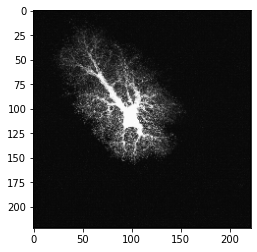

In [15]:
plt.imshow(img_noisy.max(0), cmap='gray')

Фильтрация изображения

In [16]:
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects

In [17]:
li = threshold_li(img_noisy)

In [18]:
img_filt = np.where(img_noisy > li, img_noisy, 0)
binary_clean = remove_small_objects(img_noisy >= li, 5, connectivity=3)
img_clear = np.where(binary_clean, img_filt, 0)

In [19]:
final_image = img_clear

Матрица Гессе

In [139]:
sigma = 2

In [140]:
sato, Vf = astro.hessian.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

In [141]:
Vfx = Vf[...,0][...,::-1]
V = Vfx[..., 0]
U = Vfx[..., 1]
C = Vfx[..., 2]

In [142]:
lengths = astro.enh.percentile_rescale(sato)**0.5

In [143]:
vectors = np.stack((U*lengths, V*lengths, C*lengths), axis=3)

Построение графа

In [144]:
crops = [((slice(1, None)), (slice(None, -1))),
         ((slice(1, None), slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1), slice(None, -1)), (slice(None, -1), slice(1, None), slice(1, None))),
         ((slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1)), (slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(1, None), slice(None, -1)), (slice(None, -1), slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(None, -1), slice(1, None)), (slice(None, -1), slice(1, None), slice(None, -1))),
         ((slice(1, None), slice(None), slice(None, -1)), (slice(None, -1), slice(None), slice(1, None))),
         ((slice(1, None), slice(None), slice(1, None)), (slice(None, -1), slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(1, None)), (slice(None), slice(None, -1), slice(None, -1))),
         ((slice(None), slice(1, None)), (slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(None, -1)), (slice(None), slice(None, -1), slice(1, None))),
         ((slice(None), slice(None), slice(None, -1)), (slice(None), slice(None), slice(1, None)))]

In [145]:
i, j, k = np.indices(vectors.shape[:-1])
idx = np.stack((i,j,k), axis=3)

In [146]:
G3 = nx.Graph()
nodes3 = {}

In [147]:
for crop, acrop in tqdm(crops):
    G3.add_weighted_edges_from(calc_edges(vectors[crop], vectors[acrop], idx[crop], idx[acrop]))

  0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_6023/1847692117.py:5: RuntimeWarning: invalid value encountered in true_divide
  cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)


In [148]:
nodes3 = {n:n for n in G3.nodes()}

Выделение сомы

In [83]:
from skimage.morphology import erosion, dilation

In [84]:
to_erose = final_image[:]

In [85]:
for i in range(5):
    to_erose = erosion(to_erose)

In [86]:
eroded = remove_small_objects(to_erose > 0, 5, connectivity=3)

In [87]:
soma_mask = np.where(dilation(eroded), True, False)

In [88]:
if verbose:
    w = napari.view_image(final_image)
    w.add_image(soma_mask, blending='additive', colormap='cyan')

In [89]:
soma = [tuple(i) for i in idx[soma_mask]]

Определение центра

In [90]:
import itertools as itt

In [91]:
def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

In [92]:
zstack = final_image[:]

In [93]:
%time X = np.array(list(itt.product(*map(range, zstack.shape))))

CPU times: user 1.93 s, sys: 63.2 ms, total: 1.99 s
Wall time: 1.99 s


In [94]:
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)

In [95]:
center = tuple(map(int, np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)))
center

(50, 106, 98)

Добавление точек сомы в граф

In [96]:
G = nx.complete_graph(soma)

In [97]:
nx.set_edge_attributes(G, 0.7, name='weight')

In [149]:
for p1, p2, weight in G.edges(data=True):
    try:
        old_weight = G3.get_edge_data(p1, p2)['weight']
    except:
        old_weight = 1
    G3.add_edge(p1, p2, weight=min(weight['weight'], old_weight))

In [150]:
nodes3 = {n:n for n in G3.nodes()}

In [151]:
nodes = G3.nodes()

Расчет путей

In [152]:
%time paths_dict = nx.single_source_dijkstra_path(G3, center)

CPU times: user 1.94 s, sys: 6.52 ms, total: 1.94 s
Wall time: 1.95 s


In [153]:
paths = list(paths_dict.values())

In [104]:
np.save('{}_sigma{}_paths_all'.format(os.path.basename(filename), sigma), np.array(paths, dtype=object))

Расчет встречаемости

In [154]:
points = count_points_paths(paths)

In [155]:
if verbose:
    w.add_points(draw_nodes(nodes3, points), size=1, edge_color='transparent', face_color='b', name='count')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [156]:
count_1 = []
for path in paths:
    count = 0
    for n in path:
        if points[n] == 1:
            count += 1
    count_1.append(count)

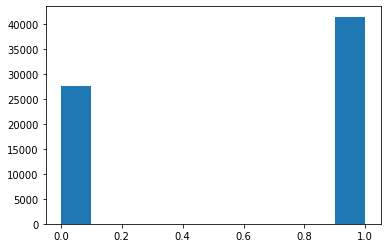

In [157]:
plt.hist(count_1)
plt.show()

In [158]:
to_del = []
for point, count in points.items():
    if count == 1:
        to_del.append(point)

In [159]:
np.save('{}_sigma{}_points_count'.format(os.path.basename(filename), sigma), np.array(points, dtype=object))

Фильтрация точек по встречаемости

In [160]:
from copy import copy
points_count = copy(points)

In [161]:
for point in to_del:
    del points_count[point]

In [162]:
sorted(points_count.values())[-20:]

[32113,
 32117,
 32119,
 32126,
 32131,
 32143,
 32151,
 32152,
 32159,
 32170,
 32179,
 32182,
 32190,
 32207,
 32209,
 32215,
 32273,
 37840,
 37851,
 69023]

In [163]:
del points_count[center]

In [164]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_count), size=1, edge_color='transparent', face_color='r', name='count')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [165]:
qstack = np.zeros(vectors.shape[:-1])
for loc, val in points_count.items():
    qstack[loc] = np.log(val)

In [166]:
if verbose:
    w.add_image(qstack)

In [167]:
p = np.asarray(list(points_count.keys()))

In [168]:
vals = np.asarray(list(points_count.values()))

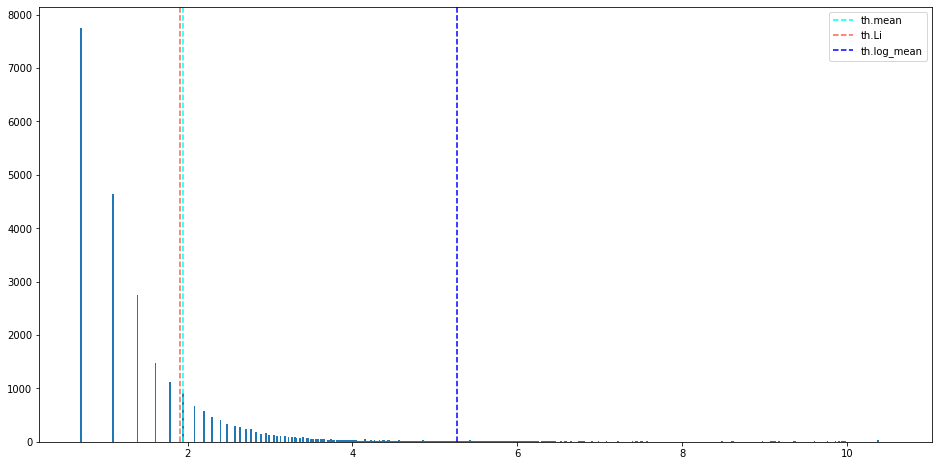

In [169]:
plt.figure(figsize=(16,8))
plt.hist(np.log(vals[vals>1]), bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(np.log(vals)), color='cyan', ls='--', label='th.mean')
plt.axvline(threshold_li(np.log(vals)), color='tomato', ls='--', label='th.Li')
plt.axvline(np.log(np.mean(vals)), color='b', ls='--', label='th.log_mean')
plt.legend()
plt.show()

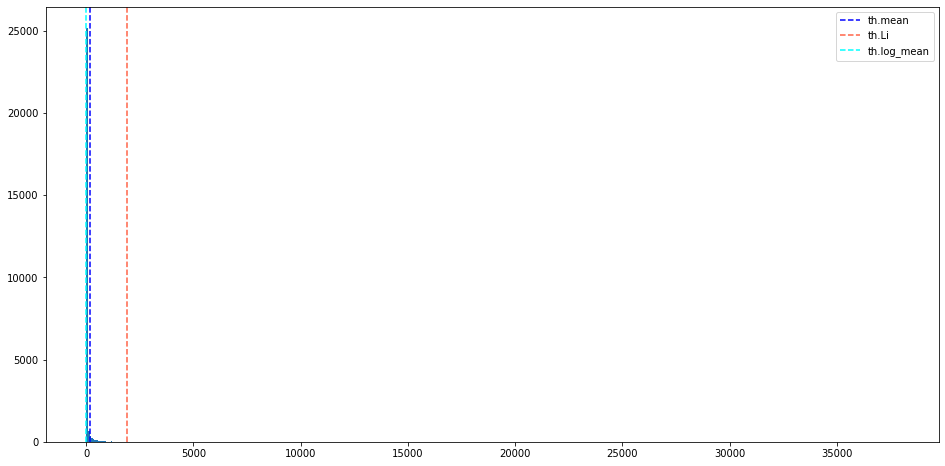

In [170]:
plt.figure(figsize=(16,8))
plt.hist(vals[vals>1], bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(vals), color='b', ls='--', label='th.mean')
plt.axvline(threshold_li(vals), color='tomato', ls='--', label='th.Li')
plt.axvline(np.exp(np.mean(np.log(vals))), color='cyan', ls='--', label='th.log_mean')
plt.legend()
plt.show()

In [171]:
points_mean = [k for k, v in points_count.items() if v > np.mean(vals)]
points_li = [k for k, v in points_count.items() if v > threshold_li(vals)]
points_log_mean = [k for k, v in points_count.items() if np.log(v) > np.mean(np.log(vals))]
points_log_li = [k for k, v in points_count.items() if np.log(v) > threshold_li(np.log(vals))]

In [172]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_mean), size=1, edge_color='transparent', face_color='m', name='filt mean')
    w.add_points(draw_nodes(nodes3, points_li), size=1, edge_color='transparent', face_color='g', name='filt li')    
    w.add_points(draw_nodes(nodes3, points_log_mean), size=1, edge_color='transparent', face_color='c', name='filt log mean')    
    w.add_points(draw_nodes(nodes3, points_log_li), size=1, edge_color='transparent', face_color='r', name='filt log li')    

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a